We are given an Ecommerce customers info dataset, where based on such info we should advise the CEO of the company of which these customers buys from, where to focus their efforts on the development of their mobile application or the website to drive sales?

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns# Setting the grid style
sns.set_style('darkgrid')
sns.set_color_codes(palette='dark')

# Setting plot area
pd.set_option('display.max_colwidth', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle("ecommerce_customers.pkl")

In [3]:
df.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, DC 99414-7564",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 37242-1057",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [4]:
# check duplicate rows
len(df.Email.unique())

500

In [5]:
df= df.drop(["Avatar","Email"],axis=1) # These columns are not useful so we drop them

In [6]:
# rename columns
df.rename(columns={"Address":"address","Avg. Session Length": "avg_session_length","Time on App":"time_on_app","Time on Website":"time_on_website",
                  "Length of Membership":"length_of_membership","Yearly Amount Spent":"yearly_amount_spent"},inplace=True)

In [7]:
# find any missingdata in dataset
df.isna().sum()

address                 0
avg_session_length      0
time_on_app             0
time_on_website         0
length_of_membership    0
yearly_amount_spent     0
dtype: int64

In [8]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
avg_session_length,500.0,33.05,0.99,29.53,32.34,33.08,33.71,36.14
time_on_app,500.0,12.05,0.99,8.51,11.39,11.98,12.75,15.13
time_on_website,500.0,37.06,1.01,33.91,36.35,37.07,37.72,40.01
length_of_membership,500.0,3.53,1.00,0.27,2.93,3.53,4.13,6.92
yearly_amount_spent,500.0,499.31,79.31,256.67,445.04,498.89,549.31,765.52


# EDA

Lets first explore this data, before using Linear Regression to make a decision, to study the correlations between the different factors and how they affect the how much the customer spends.

We will only use the numerical data

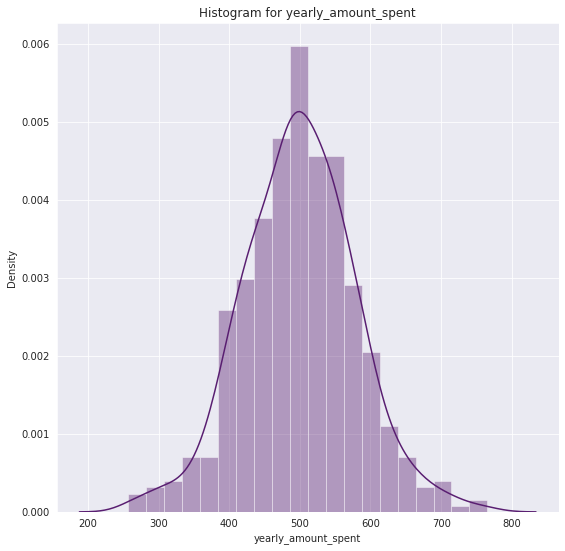

In [9]:
# Setting plot area
f, ax = plt.subplots(figsize=(9, 9))

# plotting the distribution plot
sns.distplot(df['yearly_amount_spent'], color="m", axlabel='yearly_amount_spent')
ax.set(title="Histogram for yearly_amount_spent")
plt.show()

Seems like yearly_amount_spent is normally distributed thus we don't have to normalize it.

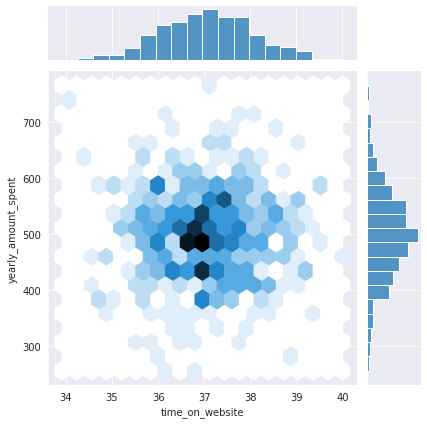

In [10]:
sns.jointplot(data=df, x="time_on_website", y="yearly_amount_spent", kind="hex")


Apperantly, Time spent on website and amount of money spent yearly do not correlate much

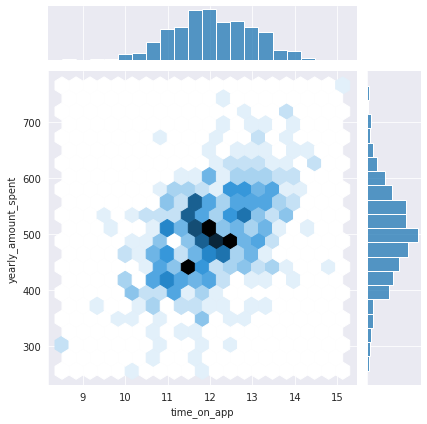

In [11]:
sns.jointplot(data=df, x="time_on_app", y="yearly_amount_spent", kind="hex")

On the other hand the amount of time spent on the app correlates more to yearly revenues, so the more time is spent on app the higher revenues we have.


Let's see if there are any other interesting correlations.


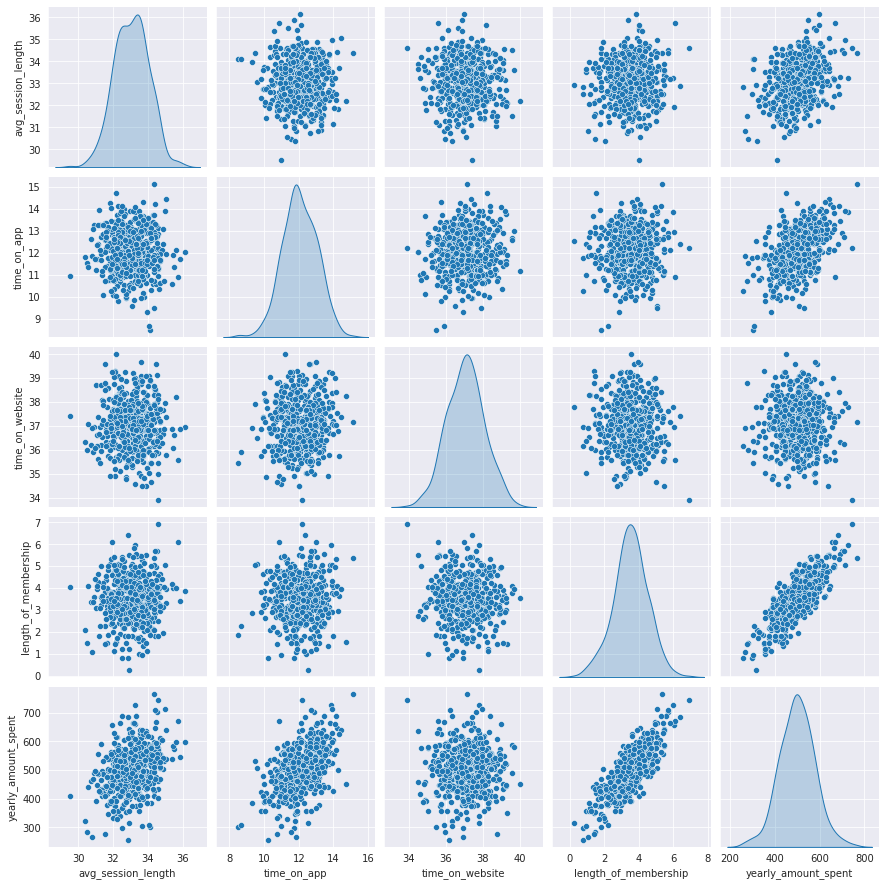

In [12]:
sns.pairplot(df, height = 2.5, kind='scatter', diag_kind="kde", dropna=True,diag_kws=dict(shade=True))

Based on this plot it seems that the length of membership feature is strongly correlated to the amount that is spent yearly.

## Now lets work on the regression model

First we will split the data into train and test sets. The feature we are interested in predicting is the yearly_amount_spent

In [13]:
X = df[['avg_session_length', 'time_on_app','time_on_website','length_of_membership']]
y = df['yearly_amount_spent']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [15]:
X_train.head()

,avg_session_length,time_on_app,time_on_website,length_of_membership
153,31.945396,12.965761,36.966389,6.076654
84,34.655486,10.338073,36.157256,4.396652
310,33.248506,11.656592,36.548605,3.363411
494,33.431097,13.350632,37.965972,2.768852
126,32.657269,11.957923,36.634652,4.106055


## Lets choose the top baseline models among the following

- Ridge regression is a penalized linear regression model for predicting a numerical value.
- KNeighborsRegressor is a regression based on k-nearest neighbors.
- SVR is Epsilon-Support Vector Regression.
- RandomForestRegressor is a random forest.
- GradientBoostingRegressor is Gradient Boosting for regression.
- DecisionTreeRegressor is a decision tree regressor.
- AdaBoostRegressor is an AdaBoost regressor.
- ExtraTreesRegressor is an extra-trees regressor.
- XGBRegressor is an Extreme Gradient Boosting regressor.

In [16]:
random_state=2

# Baseline cross validation
models = [
    XGBRegressor(random_state=random_state),
    SVR(),
    DecisionTreeRegressor(random_state=random_state),
    AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state)),
    RandomForestRegressor(random_state=random_state),
    ExtraTreesRegressor(random_state=random_state),
    GradientBoostingRegressor(random_state=random_state),
#     MLPRegressor(random_state=random_state),
    KNeighborsRegressor(),
    Ridge(random_state=random_state),
]

def evaluate_model(X, y, models,Kfold=5):
    performance = {}
    for model in models:
#         mean accuracy
        score = cross_val_score(model, X, y, cv=Kfold).mean().round(4)*100.0
        print("Model: {}, mean cross validated score: {}%".format(type(model).__name__, score))
        performance[type(model).__name__] = score
    return performance
        
model_scores = evaluate_model(X_train, y_train, models)
top_models = sorted(model_scores, key=model_scores.get, reverse=True)[:5]

print("The best models are: {}".format(top_models))

Model: XGBRegressor, mean cross validated score: 94.21000000000001%
Model: SVR, mean cross validated score: -0.15%
Model: DecisionTreeRegressor, mean cross validated score: 83.02000000000001%
Model: AdaBoostRegressor, mean cross validated score: 92.09%
Model: RandomForestRegressor, mean cross validated score: 92.61%
Model: ExtraTreesRegressor, mean cross validated score: 95.59%
Model: GradientBoostingRegressor, mean cross validated score: 94.55%
Model: KNeighborsRegressor, mean cross validated score: 88.2%
Model: Ridge, mean cross validated score: 98.33%
The best models are: ['Ridge', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'RandomForestRegressor']


In [17]:
print(GradientBoostingRegressor().get_params())

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [20]:
# Hyperparameter Tuning for the top models

GBR_params = {'n_estimators' : np.arange(100, 500, 50), # Number of boosting stages to perform
              'learning_rate': np.arange(0.01, 0.1, 0.01),
              'max_depth': np.arange(2, 10, 1), # Maximum depth of the individual regression estimators
              'min_samples_leaf': np.arange(100, 200, 10), # Minimum number of samples required to be at a leaf node
              'alpha': np.arange(0.7, 0.9, 0.05)
             }

Ridge_params = {'alpha': np.arange(0.1, 1.5, 0.1) # Regularization strength
               }

ExtraT_params = {'n_estimators' : np.arange(50,1000,50) # Number of trees in the forest
                }

Ada_params = {'n_estimators' : np.arange(50,1000,50),
              'learning_rate': np.arange(0.01, 0.1, 0.01)}

XGB_params = {'n_estimators' : np.arange(100, 2000, 100),
              'learning_rate': np.arange(0.01, 0.1, 0.01),
              'max_depth': np.arange(1, 10, 1) # Maximum depth of a tree
             }

RFR_parms = {'n_estimators' : np.arange(10, 1000, 250), # Number of trees in random forest
              'max_features': ['sqrt', 'log2'], # Number of features to consider at every split
              'max_depth': np.append(np.arange(10, 50, 10) ,None), # Maximum number of levels in tree
              'min_samples_leaf': np.arange(1, 15, 5), # Minimum number of samples required at each leaf node
              'min_samples_split': np.arange(2, 20, 5), # Minimum number of samples required to split a node
              'bootstrap' : [True, False] # Method of selecting samples for training each tree
            }

SVR_params = { 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], # Kernel type to be used in the algorithm
              'epsilon': np.arange(0.1, 0.5, 0.1), 
              'C': np.arange(1, 20, 1) #  Regularization parameter (a penality)
             }

KNR_params = {'leaf_size': np.arange(5, 50, 5),
              'n_neighbors': np.arange(1, 10, 3), # Number of neighbors 
              'p': np.arange(1, 4, 1), # Power parameter for the Minkowski metric
             'metric' : ['euclidean', 'manhattan', 'minkowski'], # Distance metrics for choosing the composition of the neighborhood
             'weights' : ['uniform', 'distance'] # Weight function used in prediction
             }

model_list = [Ridge(), ExtraTreesRegressor(), GradientBoostingRegressor(), XGBRegressor(), RandomForestRegressor()]
param_list = [Ridge_params, ExtraT_params, GBR_params, XGB_params, RFR_parms ]
      
iterations = 20
best_estimators = {}

for i in range(len(model_list)):
    model_name = type(model_list[i]).__name__
    
#     Randomized search on hyper parameters.
# define search
    fitted_model = RandomizedSearchCV(model_list[i],
                                      param_distributions = param_list[i],
                                      n_iter=iterations, 
                                      cv=5,
                                      scoring="neg_mean_squared_error", #neg_mean_absolute_error
                                      verbose=0,
                                     return_train_score = True)
# execute search to get estimators
    fitted_model.fit(X_train, y_train)
# summarize result   
    print("Model: {}, best cross validated score: {}".format(model_name, -1*fitted_model.best_score_))
    print('Model: {}, best Hyperparameters: {}'.format(model_name, fitted_model.best_params_))
    #     save the best model
    best_estimators[model_name] = fitted_model.best_estimator_
    


Model: Ridge, best cross validated score: 98.4955447455948
Model: Ridge, best Hyperparameters: {'alpha': 0.4}
Model: ExtraTreesRegressor, best cross validated score: 266.8218005836693
Model: ExtraTreesRegressor, best Hyperparameters: {'n_estimators': 650}
Model: GradientBoostingRegressor, best cross validated score: 1682.3294954062937
Model: GradientBoostingRegressor, best Hyperparameters: {'n_estimators': 350, 'min_samples_leaf': 100, 'max_depth': 5, 'learning_rate': 0.09, 'alpha': 0.7}
Model: XGBRegressor, best cross validated score: 185.44832585124425
Model: XGBRegressor, best Hyperparameters: {'n_estimators': 1500, 'max_depth': 1, 'learning_rate': 0.06999999999999999}
Model: RandomForestRegressor, best cross validated score: 506.8962410787805
Model: RandomForestRegressor, best Hyperparameters: {'n_estimators': 260, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [22]:
# A voting regressor is an ensemble meta-estimator that fits several base
# regressors, each on the whole dataset. Then it averages the individual
# predictions to form a final prediction.
voting = VotingRegressor([
    ('GradientBoostingRegressor', best_estimators['GradientBoostingRegressor']),
    ('Ridge', best_estimators['Ridge']),
    ('ExtraTreesRegressor',best_estimators['ExtraTreesRegressor']),
    ('RandomForestRegressor', best_estimators['RandomForestRegressor']),
    ('XGBRegressor', best_estimators['XGBRegressor'])
])

voting = voting.fit(X_train, y_train)
preds = voting.predict(X_test)

In [23]:
from math import sqrt
print("MAE:", metrics.mean_absolute_error(y_test, preds))
print("MSE:", metrics.mean_squared_error(y_test, preds))
print("RMSE:", sqrt(metrics.mean_squared_error(y_test, preds)))

MAE: 12.024579028831683
MSE: 257.3846880293157
RMSE: 16.043213145418086


Text(0, 0.5, 'Predicted Y')

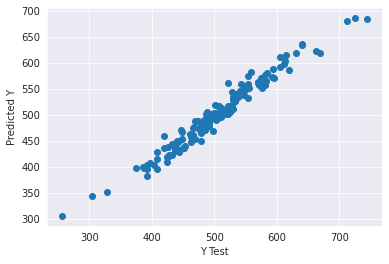

In [24]:
plt.scatter(y_test,preds)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

Lets print out the coefficients of the RIDGE regression model which is a variation of Linear Regression


In [25]:
best_estimators['Ridge'].coef_

array([26.12748385, 38.58008034,  0.31908648, 61.75443778])

Now lets test the ridge model using the test data (for which we already have the labels) to see how will it perform

In [26]:
prediction = best_estimators['Ridge'].predict(X_test)

Text(0, 0.5, 'Predicted Y')

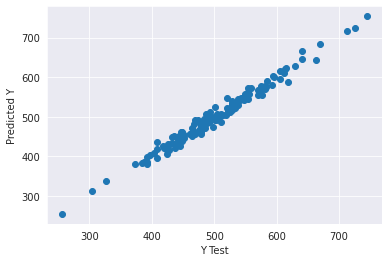

In [27]:
plt.scatter(y_test,prediction)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

The model seem pretty good!


Now lets evaluate the model performance with some metrics. 

we will calculate the Mean Absolute Error (MAE), Mean Squared Error (MSE), and the Root Mean Squared Error (RMSE)

In [28]:
print("MAE:", metrics.mean_absolute_error(y_test, prediction))
print("MSE:", metrics.mean_squared_error(y_test, prediction))
print("RMSE:", sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 8.505191699359484
MSE: 114.20988562261832
RMSE: 10.68690252704769


## Finally


We still want to find out the answer to the original question, do we advice the CEO to focus their efforst on mobile app or website development? Or maybe that doesn't even really matter, and Membership Time is what is really important. Let's see if we can interpret the coefficients at all to get an idea.


In [29]:
coeffecients = pd.DataFrame(best_estimators['Ridge'].coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
avg_session_length,26.127484
time_on_app,38.580080
time_on_website,0.319086
length_of_membership,61.754438




Lets interpret these coefficients:

Holding all other variables fixed, one unit of increase in:

- Avg. Session Length increases the Yearly Amount Spent by almost 26 units
- Time on App increases the Yearly Amount Spent by 38 units
- Time on Website increases the Yearly Amount Spent by 0.3 units
- Length of Membership increases the Yearly Amount Spent by 61 units

The Time on Website seems to have very little influence on the Yearly Amount Spent comparing to the Time on App  of which shows a stronger correlation with the Yearly Amount Spent. Considering that, its tricky to choose between app and website. The mobile App is performing better compared to the website, so we can advice the CEO to develop the Website to catch up to the performance of the mobile app if there aim is to make both app and website  make same revenue, or to develop the app more if they care more about what is working better. So basically it depends on their goal. Moreover, we can advice them to explore the relationship between Length of Membership and the App or the Website before coming to a final conclusion since the most important variable that influence the spending is the Length of Membership.

